In [1]:
# Visualization
import plotly.express as px # for data visualization

# Sklearn
from sklearn.datasets import load_digits # for MNIST data
from sklearn.datasets import make_swiss_roll # for swiss roll
from sklearn.manifold import Isomap # for Isomap dimensionality reduction
from sklearn.manifold import MDS # for MDS dimensionality reduction
from sklearn.preprocessing import StandardScaler # for data standardization
from sklearn.decomposition import PCA # for PCA analysis

from tqdm import tqdm
import torch
from torch_tda.nn import RipsLayer, Rips0Layer, BottleneckLayer, WassersteinLayer,\
BarcodePolyFeature
from herabottleneck import BottleneckLayerHera

from PH_projection_pursuit import bottleneck_proj_pursuit, subsample_bats, cayley_update
import glob
import numpy as np
import matplotlib.pyplot as plt
import bats
from sklearn.metrics.pairwise import pairwise_distances
from dr_visualization import plot_H1, PD_uncertainty, plotly_2D_scatter

In [46]:
def plotly_2D_scatter(X_trans, y, save_path = None, leave_out = 0.1, **kwargs):
    '''
    Draw dimension reduction results
    
    Input
    ------
    X_trans: datasets after dimension reduction in R^2
    y: color/label
    
    '''

    # Create a scatter plot
    fig = px.scatter(None, x=X_trans[:,0], y=X_trans[:,1], opacity=1, color=y)
    fig.update(layout_coloraxis_showscale=False) # remove color bar
    
    # Change chart background color
    fig.update_layout(dict(plot_bgcolor = 'white'))

    # Update axes lines
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    
    
    x_low_limit, y_low_limit = np.min(X_trans, axis = 0)
    x_high_limit, y_high_limit = np.max(X_trans, axis = 0)
    fig.update_xaxes(range=[x_low_limit-leave_out, x_high_limit + leave_out])
    fig.update_yaxes(range=[y_low_limit-leave_out, y_high_limit + leave_out])

    # Set figure title
#     fig.update_layout(title_text= title_txt)

    # Update marker size
    fig.update_traces(marker=dict(size=5,
                                 line=dict(color='black', width=0.2)))
    
    fig.update_layout(**kwargs)
    
    if save_path:
        fig.write_image(save_path)

    return fig

In [2]:
def compute_PH_for_H1_plot(X):
    DX = pairwise_distances(X)
    rX = bats.enclosing_radius(bats.Matrix(DX))
    F = bats.LightRipsFiltration(bats.Matrix(DX), rX , 2)
    R = bats.reduce(F, bats.F2()) # do not add any flags when plot
    ps1 = R.persistence_pairs(1)
#     fig, ax = bats.persistence_diagram(ps)
    return F, R, DX, ps1

def PH_uncert_plot(X, uncertainty_length, save_path = None):
    DX = pairwise_distances(X)
    rX = bats.enclosing_radius(bats.Matrix(DX))
    F = bats.LightRipsFiltration(bats.Matrix(DX), rX , 2)
    flags = (bats.extra_reduction_flag(), bats.clearing_flag())
    R = bats.reduce(F, bats.F2(), *flags)
    ps = []
    for i in range(2):
        ps.extend(R.persistence_pairs(i))
        
    fig, ax = PD_uncertainty(ps, uncertainty_length)
    ax.set_title(f"Unconfident Bandwidth {uncertainty_length:.3f}")
    if save_path:
        fig.savefig(save_path, format="pdf", bbox_inches='tight')

def PH_compute(X, ps_length_thres):
    DX = pairwise_distances(X)
    rX = bats.enclosing_radius(bats.Matrix(DX))
    # maixmum complex dimension = maximum homology dimension + 1
    F = bats.LightRipsFiltration(bats.Matrix(DX), rX , 2)
    flags = (bats.extra_reduction_flag(), bats.clearing_flag())
    R = bats.reduce(F, bats.F2(), *flags)
    ps = []
    for i in range(2):
        ps.extend(R.persistence_pairs(i))

    fig, ax = bats.persistence_diagram(ps)

    for p in ps:
        if p.death() != np.inf and p.death() - p.birth() > ps_length_thres:
            print(p)

In [3]:
def cayley_bottleneck_pursuit(X, opt_dim = 1):
    Xt = torch.tensor(X, dtype=torch.double)
    layer = RipsLayer(maxdim=1, metric = 'euclidean')
    ground_truth_dgm = layer(Xt)

    pca = PCA(n_components=2).fit(X)
    P = pca.components_ # using the orthonormal matrix from PCA 
    P = P.T
    Pt = torch.tensor(P, dtype=torch.double, requires_grad=True)

    crit = BottleneckLayerHera()
    lrs = np.hstack((np.repeat(1e-3,15), np.repeat(1e-4,105), np.repeat(1e-5,50)))
    losses = []
    for lr in tqdm(lrs):
        Yt = torch.mm(Xt, Pt)
        Y_dgm = layer(Yt)
        
        if opt_dim == 1:
            bd1 = crit(Y_dgm[1], ground_truth_dgm[1])
            loss = bd1
        elif opt_dim == 10:
            bd0 = crit(Y_dgm[0], ground_truth_dgm[0])
            bd1 = crit(Y_dgm[1], ground_truth_dgm[1])
            loss = bd0 + bd1
        else:
            bd0 = crit(Y_dgm[0], ground_truth_dgm[0])
            loss = bd0
            
        losses.append(loss.detach().numpy())
    #     print(loss.detach().numpy())

        try:
            Pt.grad.zero_()
        except:
            pass

        loss.backward()

        # detach from torch to do update
        dP = Pt.grad.detach().numpy()
        P = cayley_update(P, dP, lr)
        # put back in tensor
        Pt.data = torch.tensor(P)
    
    return Pt, losses

In [4]:
def compute_bot_dist_b0_b1(X,Y):
    layer = RipsLayer(maxdim=1, sparse = True, 
                  reduction_flags=(bats.standard_reduction_flag(), 
                                             bats.clearing_flag(),))
    crit = BottleneckLayerHera()
    Xt = torch.tensor(X, dtype=torch.double)
    Yt = torch.tensor(Y, dtype=torch.double)
    X_dgm = layer(Xt)
    Y_dgm = layer(Yt)
    bd0 = crit(Y_dgm[0], X_dgm[0])
    bd1 = crit(Y_dgm[1], X_dgm[1])
#     bd = max(bd0.detach().numpy(), bd1.detach().numpy())
    return bd0.item(), bd1.item()


In [5]:
def generate_circle(n = 100, p = 4, ind_x=0, ind_y=1, rad = 1, sigma = 0.05):
    # ind_x: the index of dimension where x-axis of cycle lies in
    # ind_y: the index of dimension where y-axis of cycle lies in
    
    thetas = np.arange(0, n) * 2 * np.pi / n
    rs = rad * np.ones(n)
    X = np.hstack((sigma*np.random.randn(n, ind_x),
                   (rs * np.cos(thetas)).reshape(-1,1) + 1,
                   sigma*np.random.randn(n, ind_y - ind_x - 1),
                   (rs * np.sin(thetas)).reshape(-1,1) + 1,
                   sigma*np.random.randn(n, p - ind_y -1)))
    
    return X

In [6]:
def PH_compute(X):
    DX = pairwise_distances(X)
    rX = bats.enclosing_radius(bats.Matrix(DX))
    # maixmum complex dimension = maximum homology dimension + 1
    F = bats.LightRipsFiltration(bats.Matrix(DX), rX , 2)
    flags = (bats.extra_reduction_flag(), bats.clearing_flag())
    R = bats.reduce(F, bats.F2(), *flags)
    ps = R.persistence_pairs(1)

    fig, ax = bats.persistence_diagram(ps)

    for p in ps:
        if p.death() != np.inf and p.death() - p.birth() > 0.5:
    #     if p.dim() == 1 and p.death() != np.inf and p.death() - p.birth() > 1e-3:
            print(p)

In [7]:
def generate_X(n_pt_cirlce, p):
#     p  : dimension of whole space
#     n_pt_cirlce : number of points in each circle
    X = generate_circle(n_pt_cirlce, p, 0, 1)
    labels = np.ones(len(X))
    k = 1
    for i in range(p):
        for j in range(i+1,p):
            if (i,j) != (0,1):
                X = np.vstack((X, generate_circle(n_pt_cirlce, p, i, j) ))
                labels = np.hstack((labels, np.ones(n_pt_cirlce) + k))
                k+=1
    return X, labels

X, labels = generate_X(50, 5)

In [8]:
X.shape # hope to see 6 circles

(500, 5)

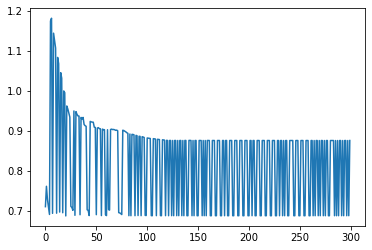

In [25]:
Y, indsY, dHY = subsample_bats(X, k = 200)
# flags = (bats.extra_reduction_flag(),bats.compression_flag())
P, opt_info = bottleneck_proj_pursuit(Y, scheduler_iter = 15, opt_dim=1,
                                      optimizer_iter = 20)
plt.plot(opt_info['losses'])

In [26]:
opt_info['losses'][-1]

array(0.87597962)

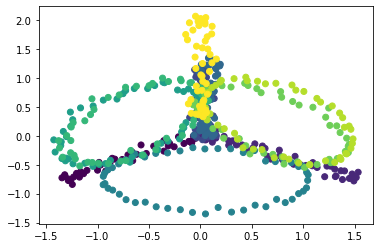

In [27]:
X_PH = X @ P.T
plt.scatter(X_PH[:,0], X_PH[:,1], c = labels)

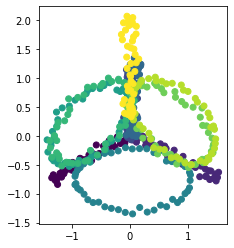

In [62]:
method_name = 'PH'
save_path = 'images/ortho_cycle/'+method_name+'.pdf'
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(X_PH[:,0], X_PH[:,1], c = labels)
ax.set_aspect('equal', adjustable='box')
plt.savefig(save_path, dpi=150, bbox_inches='tight')

In [47]:
X_dr = X_PH
y = labels
method_name = 'PH'
plotly_2D_scatter(X_dr, y,
                  save_path = 'images/ortho_cycle/'+method_name+'.pdf',
                  width=400, height=400, leave_out = 0.1,
                  autosize=False, margin = {'l':0,'r':0,'t':0,'b':0})

### X_PH2

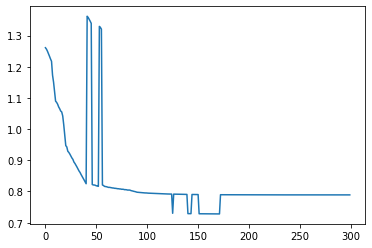

In [31]:
Y, indsY, dHY = subsample_bats(X, k = 200)
# flags = (bats.extra_reduction_flag(),bats.compression_flag())
P, opt_info = bottleneck_proj_pursuit(Y, scheduler_iter = 15, opt_dim=1,
                                      optimizer_iter = 20)
plt.plot(opt_info['losses'])


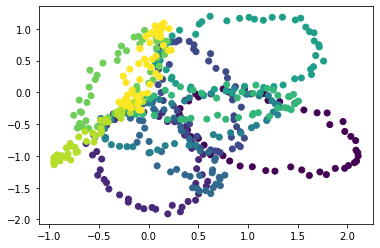

In [32]:
X_PH2 = X @ P.T
plt.scatter(X_PH2[:,0], X_PH2[:,1], c = labels)

In [ ]:
plotly_2D_scatter(X_dr, y,
                  save_path = 'images/Coil-100/tomato_'+method_name+'.pdf',
                  width=400, height=400, 
                  autosize=False, margin = {'l':0,'r':0,'t':0,'b':0})

## PCA

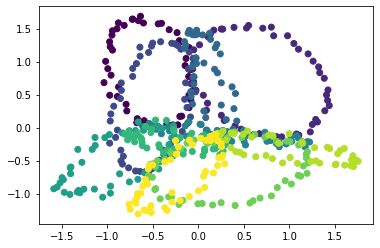

In [12]:
from sklearn.decomposition import PCA
X_pca = PCA(n_components=2).fit_transform(X)
plt.scatter(X_pca[:,0], X_pca[:,1], c)

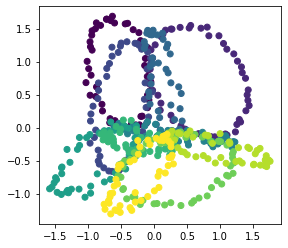

In [61]:
method_name = 'PCA'
save_path = 'images/ortho_cycle/'+method_name+'.pdf'
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(X_pca[:,0], X_pca[:,1], c = labels)
ax.set_aspect('equal', adjustable='box')
plt.savefig(save_path, dpi=150, bbox_inches='tight')

In [48]:
X_dr = X_pca
y = labels
method_name = 'PCA'
plotly_2D_scatter(X_dr, y,
                  save_path = 'images/ortho_cycle/'+method_name+'.pdf',
                  width=400, height=400, leave_out = 0.1,
                  autosize=False, margin = {'l':0,'r':0,'t':0,'b':0})

## MDS

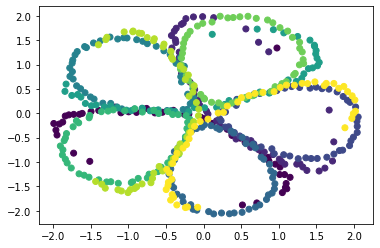

In [34]:
### Step 1 - Configure MDS function, 
model2d=MDS(n_components=2, 
          metric=True, 
          n_init=4, 
          max_iter=300, 
          verbose=0, 
          eps=0.001, 
          n_jobs=None, 
          random_state=42, 
          dissimilarity='euclidean')

### Step 2 - Fit the data and transform it
X_MDS = model2d.fit_transform(X)
plt.scatter(X_MDS[:,0], X_MDS[:,1], c = labels)

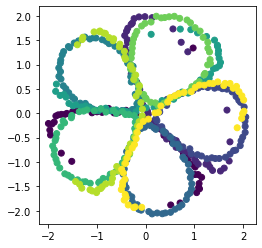

In [60]:
method_name = 'MDS'
save_path = 'images/ortho_cycle/'+method_name+'.pdf'
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(X_MDS[:,0], X_MDS[:,1], c = labels)
ax.set_aspect('equal', adjustable='box')
plt.savefig(save_path, dpi=150, bbox_inches='tight')

In [49]:
X_dr = X_MDS
y = labels
method_name = 'MDS'
plotly_2D_scatter(X_dr, y,
                  save_path = 'images/ortho_cycle/'+method_name+'.pdf',
                  width=400, height=400, leave_out = 0.1,
                  autosize=False, margin = {'l':0,'r':0,'t':0,'b':0})

## ISOMAP

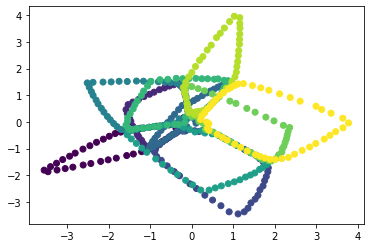

In [35]:
embed = Isomap(
    n_neighbors=5, # default=5, algorithm finds local structures based on the nearest neighbors
    n_components=2, # number of dimensions
    eigen_solver='auto', # {‘auto’, ‘arpack’, ‘dense’}, default=’auto’
    tol=0, # default=0, Convergence tolerance passed to arpack or lobpcg. not used if eigen_solver == ‘dense’.
    max_iter=None, # default=None, Maximum number of iterations for the arpack solver. not used if eigen_solver == ‘dense’.
    path_method='auto', # {‘auto’, ‘FW’, ‘D’}, default=’auto’, Method to use in finding shortest path.
    neighbors_algorithm='auto', # neighbors_algorithm{‘auto’, ‘brute’, ‘kd_tree’, ‘ball_tree’}, default=’auto’
    n_jobs=-1, # n_jobsint or None, default=None, The number of parallel jobs to run. -1 means using all processors
    metric='minkowski', # string, or callable, default=”minkowski”
    p=2, # default=2, Parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2
    metric_params=None # default=None, Additional keyword arguments for the metric function.
)

### Step 2 - Fit the data and transform it, so we have 3 dimensions instead of 64
X_isomap = embed.fit_transform(X)


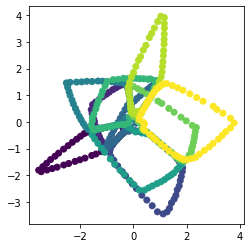

In [59]:
method_name = 'ISOMAP'
save_path = 'images/ortho_cycle/'+method_name+'.pdf'
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(X_isomap[:,0], X_isomap[:,1], c = labels)
ax.set_aspect('equal', adjustable='box')
plt.savefig(save_path, dpi=150, bbox_inches='tight')

In [50]:
X_dr = X_isomap
y = labels
method_name = 'ISOMAP'
plotly_2D_scatter(X_dr, y,
                  save_path = 'images/ortho_cycle/'+method_name+'.pdf',
                  width=400, height=400, leave_out = 0.1,
                  autosize=False, margin = {'l':0,'r':0,'t':0,'b':0})

Text(0.5, 1.0, 'Rasterization z$<-10$')

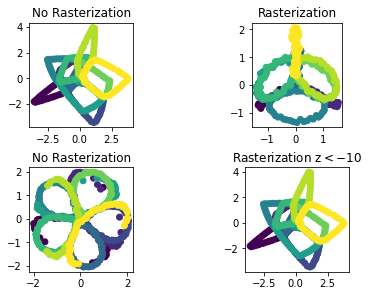

In [52]:
# d = np.arange(100).reshape(10, 10)  # the values to be color-mapped
# x, y = np.meshgrid(np.arange(11), np.arange(11))

# theta = 0.25*np.pi
# xx = x*np.cos(theta) - y*np.sin(theta)  # rotate x by -theta
# yy = x*np.sin(theta) + y*np.cos(theta)  # rotate y by -theta

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout=True)

# pcolormesh without rasterization
ax1.set_aspect(1)
ax1.scatter(X_isomap[:,0], X_isomap[:,1], c = labels)
ax1.set_title("No Rasterization")

# pcolormesh with rasterization; enabled by keyword argument
ax2.set_aspect(1)
ax2.scatter(X_PH[:,0], X_PH[:,1], c = labels)
ax2.set_title("Rasterization")
# m = ax2.pcolormesh(xx, yy, d, rasterized=True)

# pcolormesh with an overlaid text without rasterization
ax3.set_aspect(1)
ax3.scatter(X_MDS[:,0], X_MDS[:,1], c = labels)
# ax3.pcolormesh(xx, yy, d)
# ax3.text(0.5, 0.5, "Text", alpha=0.2,
#          va="center", ha="center", size=50, transform=ax3.transAxes)
ax3.set_title("No Rasterization")

# pcolormesh with an overlaid text without rasterization; enabled by zorder.
# Setting the rasterization zorder threshold to 0 and a negative zorder on the
# pcolormesh rasterizes it. All artists have a non-negative zorder by default,
# so they (e.g. the text here) are not affected.
ax4.set_aspect(1)
ax4.scatter(X_isomap[:,0], X_isomap[:,1], c = labels)
# m = ax4.pcolormesh(xx, yy, d, zorder=-10)
# ax4.text(0.5, 0.5, "Text", alpha=0.2,
#          va="center", ha="center", size=50, transform=ax4.transAxes)
# ax4.set_rasterization_zorder(0)
ax4.set_title("Rasterization z$<-10$")

# Save files in pdf and eps format
# plt.savefig("test_rasterization.pdf", dpi=150)
# plt.savefig("test_rasterization.eps", dpi=150)

# if not plt.rcParams["text.usetex"]:
#     plt.savefig("test_rasterization.svg", dpi=150)
    # svg backend currently ignores the dpi

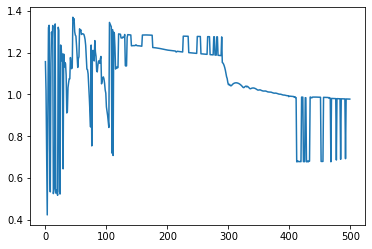

In [13]:
Y, dHY = subsample_bats(X, k = 100)
P, bottleneckD, losses, lrs = bottleneck_proj_pursuit(Y, opt_dim = 1, 
                                                      scheduler_iter = 5,
                                                      optimizer_iter = 100)
plt.plot(losses)

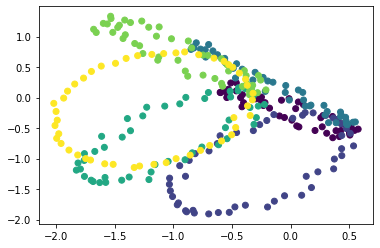

In [14]:
X_PH = X @ P.T
plt.scatter(X_PH[:,0], X_PH[:,1], c = labels)

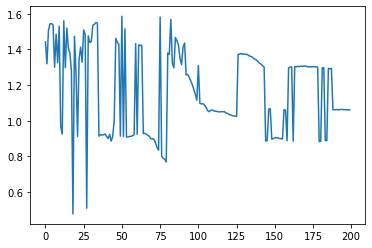

In [12]:
Y, dHY = subsample_bats(X, k = 100)
P, bottleneckD, losses, lrs = bottleneck_proj_pursuit(Y, opt_dim=10, 
                                                      scheduler_iter=5,
                                                      optimizer_iter=40)
plt.plot(losses)

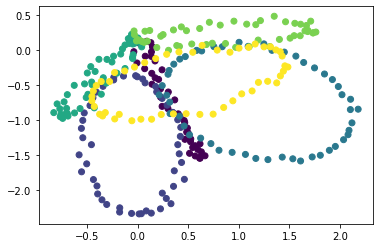

In [13]:
X_PH = X @ P.T
plt.scatter(X_PH[:,0], X_PH[:,1], c = labels)

In [14]:
lrs

[[0.005], [0.0025], [0.00125], [0.000625], [0.0003125]]